In [1]:
# Q-Learning (tabular) — Simple 4x4 GridWorld with visualization
# Paste this into a single Jupyter cell and run.
# Only standard libs: numpy, matplotlib, pandas (optional but included).
# Purpose: minimal, well-documented, educational implementation + visualizations.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
plt.rcParams['figure.dpi'] = 100

In [2]:
# -------------------------
# Simple GridWorld Env
# -------------------------
class GridWorld:
    """
    Deterministic GridWorld.
    - Square grid of size `size` x `size`.
    - Start and goal are (row, col) tuples.
    - Actions: 0=up, 1=right, 2=down, 3=left
    - step returns: next_state_index, reward, done
    """
    def __init__(self, size=4, start=(0,0), goal=(3,3), step_cost=-0.01, goal_reward=1.0):
        self.size = size
        self.start = start
        self.goal = goal
        self.step_cost = step_cost
        self.goal_reward = goal_reward
        self.state = None

    def reset(self):
        """Reset environment and return start state index."""
        self.state = self.start
        return self._to_index(self.state)

    def step(self, action):
        """Apply action and return (state_idx, reward, done)."""
        r, c = self.state
        if action == 0:       # up
            r -= 1
        elif action == 1:     # right
            c += 1
        elif action == 2:     # down
            r += 1
        elif action == 3:     # left
            c -= 1
        else:
            raise ValueError("Invalid action")

        # keep inside grid bounds
        r = max(0, min(self.size - 1, r))
        c = max(0, min(self.size - 1, c))

        self.state = (r, c)
        done = (self.state == self.goal)
        reward = self.goal_reward if done else self.step_cost
        return self._to_index(self.state), reward, done

    def _to_index(self, pos):
        return pos[0] * self.size + pos[1]

    def _from_index(self, idx):
        return (idx // self.size, idx % self.size)

    @property
    def n_states(self):
        return self.size * self.size

    @property
    def n_actions(self):
        return 4


In [3]:
# -------------------------
# Hyperparams & Q-table
# -------------------------
env = GridWorld(size=4, start=(0,0), goal=(3,3), step_cost=-0.01, goal_reward=1.0)

n_states = env.n_states
n_actions = env.n_actions
Q = np.zeros((n_states, n_actions))   # tabular Q-table

alpha = 0.1          # learning rate
gamma = 0.99         # discount factor
epsilon = 1.0        # initial epsilon for exploration
epsilon_min = 0.05
epsilon_decay = 0.995

episodes = 2500
max_steps = 100
rewards = []
moving_avg_window = 50

# Optional: store episode lengths to monitor learning speed
episode_lengths = []

In [4]:

# -------------------------
# Training loop (Q-Learning)
# -------------------------
for ep in range(episodes):
    s = env.reset()
    total_r = 0.0
    steps = 0
    while True:
        # epsilon-greedy action selection
        if np.random.rand() < epsilon:
            a = np.random.randint(n_actions)
        else:
            a = int(np.argmax(Q[s]))

        s2, r, done = env.step(a)
        # Q-learning update
        Q[s, a] += alpha * (r + gamma * np.max(Q[s2]) - Q[s, a])

        s = s2
        total_r += r
        steps += 1

        if done or steps >= max_steps:
            break

    rewards.append(total_r)
    episode_lengths.append(steps)
    # decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # print progress occasionally
    if (ep + 1) % 500 == 0:
        avg_recent = np.mean(rewards[-500:])
        print(f"Episode {ep+1}/{episodes}  avg_reward(last500)={avg_recent:.3f}  epsilon={epsilon:.3f}")

print("Training finished.")

Episode 500/2500  avg_reward(last500)=0.881  epsilon=0.082
Episode 1000/2500  avg_reward(last500)=0.947  epsilon=0.050
Episode 1500/2500  avg_reward(last500)=0.947  epsilon=0.050
Episode 2000/2500  avg_reward(last500)=0.947  epsilon=0.050
Episode 2500/2500  avg_reward(last500)=0.947  epsilon=0.050
Training finished.


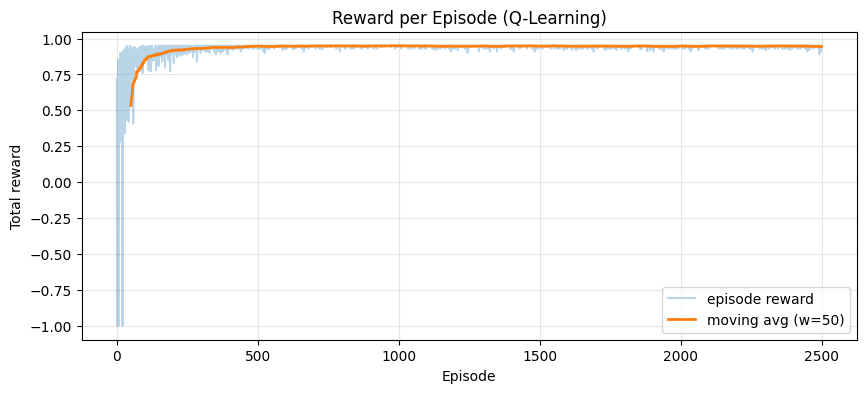

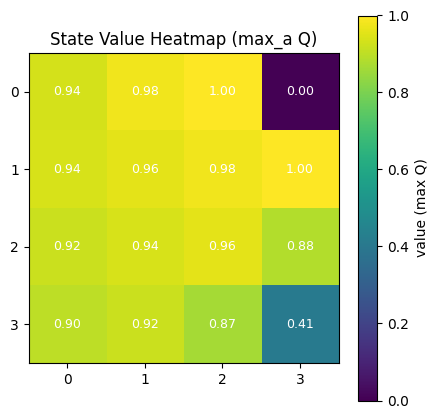

In [5]:
# -------------------------
# Visualization 1: Rewards (raw + smoothed)
# -------------------------
def moving_average(x, w):
    if len(x) < w: 
        return np.array(x)
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.3, label='episode reward')
ma = moving_average(rewards, moving_avg_window)
plt.plot(np.arange(len(ma)) + moving_avg_window - 1, ma, label=f'moving avg (w={moving_avg_window})', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Reward per Episode (Q-Learning)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -------------------------
# Visualization 2: State Value Heatmap (max_a Q(s,a))
# -------------------------
value_map = np.max(Q, axis=1).reshape(env.size, env.size)
plt.figure(figsize=(5,5))
plt.imshow(value_map[::-1], cmap='viridis', interpolation='nearest')  # flip for nicer orientation
plt.colorbar(label='value (max Q)')
plt.title('State Value Heatmap (max_a Q)')
# annotate each cell with value
for i in range(env.size):
    for j in range(env.size):
        val = value_map[env.size - 1 - i, j]  # flipped display
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=9)
plt.xticks(range(env.size))
plt.yticks(range(env.size))
plt.show()


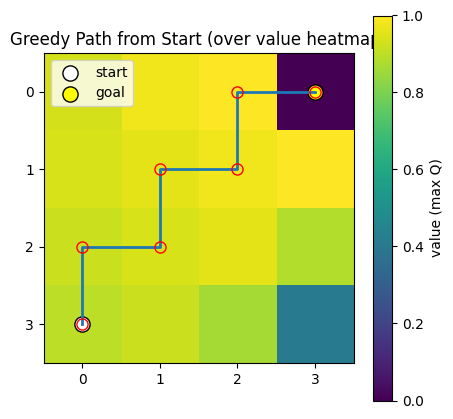

In [6]:
# -------------------------
# Visualization 3: Optimal Path from Start (greedy policy)
# -------------------------
# Simulate greedy walk from start using learned Q (stop when stuck or reach goal)
s = env.reset()
path = [s]
visited = set([s])
for step in range(50):  # safety cap
    a = int(np.argmax(Q[s]))
    s, _, done = env.step(a)
    path.append(s)
    # break if loop or goal
    if done:
        break
    if s in visited:
        # detected loop, stop
        break
    visited.add(s)

# Create grid visualization
grid = np.zeros((env.size, env.size), dtype=int)
for idx in path:
    r, c = env._from_index(idx)
    grid[r, c] = 1

# show path overlay on value heatmap
plt.figure(figsize=(5,5))
plt.imshow(value_map[::-1], cmap='viridis', interpolation='nearest')
plt.colorbar(label='value (max Q)')
# overlay path (convert coordinates to display coordinates)
display_path_coords = [(env.size - 1 - (idx // env.size), idx % env.size) for idx in path]
ys, xs = zip(*display_path_coords)
plt.plot(xs, ys, marker='o', linewidth=2, markersize=8, markerfacecolor='none', markeredgecolor='r')
# mark start and goal explicitly
sr, sc = env.start
gr, gc = env.goal
plt.scatter([sc], [env.size - 1 - sr], c='white', s=120, edgecolors='k', label='start')
plt.scatter([gc], [env.size - 1 - gr], c='yellow', s=120, edgecolors='k', label='goal')
plt.title('Greedy Path from Start (over value heatmap)')
plt.legend(loc='upper left')
plt.xticks(range(env.size))
plt.yticks(range(env.size))
plt.show()


In [7]:

# -------------------------
# Optional: print top of Q-table as DataFrame for inspection
# -------------------------
df = pd.DataFrame(Q, columns=['up', 'right', 'down', 'left'])
df.index = [f"s{idx}" for idx in range(len(df))]
print("Q-table (first 16 states):")
display(df.head(16))


Q-table (first 16 states):


,up,right,down,left
s0,0.881548,0.898300,0.901980,0.882675
s1,0.503654,0.599644,0.921176,0.607575
s2,0.277979,0.168349,0.866460,0.259767
s3,0.171453,0.080337,0.407161,0.234632
s4,0.882006,0.921192,0.919846,0.901500
s5,0.899080,0.939786,0.940598,0.901468
s6,0.543039,0.657209,0.960200,0.702281
s7,0.145128,0.410727,0.884728,0.417444
s8,0.599460,0.940592,0.751856,0.752189
s9,0.919159,0.960200,0.959913,0.919258
